In [1]:
import numpy as np
import math
import pickle
import operator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib2
import time
from scipy.misc import imread
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
import random

In [2]:
DATA_PATH = "/home/will/cvdata/workspace/data2/"

In [3]:
# Topics count (7, 20, 50, 100)
NUM_TOPIC = 7
# Features for Topics
NUM_FEATURE = 4096
# Amount of images being classified
NUM_IMAGE = 5000

In [4]:
# Load image data
img_list = np.load(DATA_PATH + 'image_list_yfcc100m_output_100k_crop.npy')
print(img_list.shape)

(99939,)


In [5]:
# Load Training set data
X = np.load(DATA_PATH + 'one_hot_yfcc100m.npy')

In [6]:
# Get data statistics, as a sanity check
print("Daxta shape: ", X.shape)
print("Number of 0s: ", np.sum(X == 1))
print("Number of 1s: ", np.sum(X == 0))
print("Anomailes: ",np.sum([X < 0]))

('Daxta shape: ', (99939, 4096))
('Number of 0s: ', 52660733)
('Number of 1s: ', 356689411)
('Anomailes: ', 0)


In [7]:
# Prepare for corpus
corpus = [[(j, X[i, j]) for j in range(NUM_FEATURE) if X[i, j]==1] for i in range(NUM_IMAGE)]
corpora.MmCorpus.serialize(DATA_PATH + 'corpus.mm', corpus)

# # Load corpus
# corpus = corpora.MmCorpus(DATA_PATH + 'corpus.mm')

In [8]:
curr_time = str(int(time.time()))
model_name = str(NUM_TOPIC) + '-topics.model'
topics_file_name = 'topic_model_features_' + str(NUM_TOPIC) +'_topics_'+ curr_time + '.npy'
topics_per_image_file_name = 'topics_per_image-' + str(NUM_TOPIC) +'_topics_'+ curr_time + '.npy'
print("Loading model: " + model_name)

Loading model: 7-topics.model


In [9]:
# Create the Topic Model
lda = models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPIC)
lda.save(DATA_PATH + model_name)
# # load trained data
# lda = models.ldamodel.LdaModel.load(DATA_PATH + model_name)

# Get topic for each image
img_by_topic = [[] for _ in range(NUM_TOPIC)]

for i in range(NUM_IMAGE):
    ind, val = sorted(lda.get_document_topics(corpus[i]), key=lambda x:x[1])[-1]
    img_by_topic[ind].append((i, val))

for j in range(NUM_TOPIC):
    img_by_topic[j].sort(key = lambda x: -x[1])

# Save results
with open(DATA_PATH + str(NUM_TOPIC) + "-topic-res.txt", "wb") as fp:
    pickle.dump(img_by_topic, fp)

In [10]:
# Visualize
def visualize(img_list, img_by_topic):
    top_list = range(NUM_TOPIC)
    for topic in top_list:
        fig, ax = plt.subplots(nrows=5, ncols=5, dpi=160)
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
        fig.suptitle(str(NUM_TOPIC)+' Topics: Topic '+str(topic+1))
        i = 0
        for row in ax:
            for col in row:
                if len(img_by_topic[topic]) <= i:
                    continue
                image_url = 'https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images'+img_list[img_by_topic[topic][i][0]].split('data')[2]
                # create a file-like object from the url
                f = urllib2.urlopen(image_url)
                # read the image from url
                I = plt.imread(f,  format='jpg')
                min_dim = min(I.shape[0],I.shape[1])
                r = 227.0/min_dim
                new_width = I.shape[0]*r
                new_height = I.shape[1]*r
                I = imresize(I,(int(math.ceil(new_width)),int(math.ceil(new_height)),3))
                I = I[0:227,0:227,:3]
                i += 1
                col.axis('off')
                col.set_title(i, fontsize=5)
                col.imshow(I)
        plt.show()     


/home/will/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


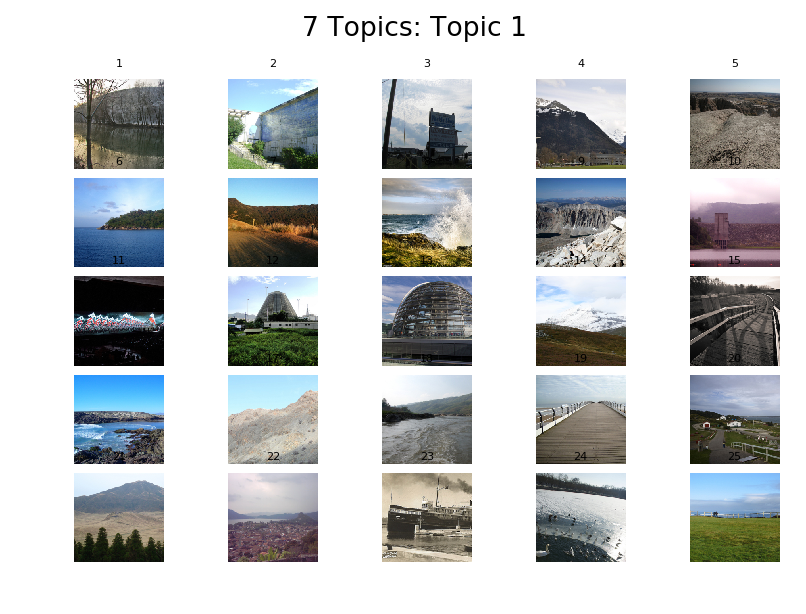

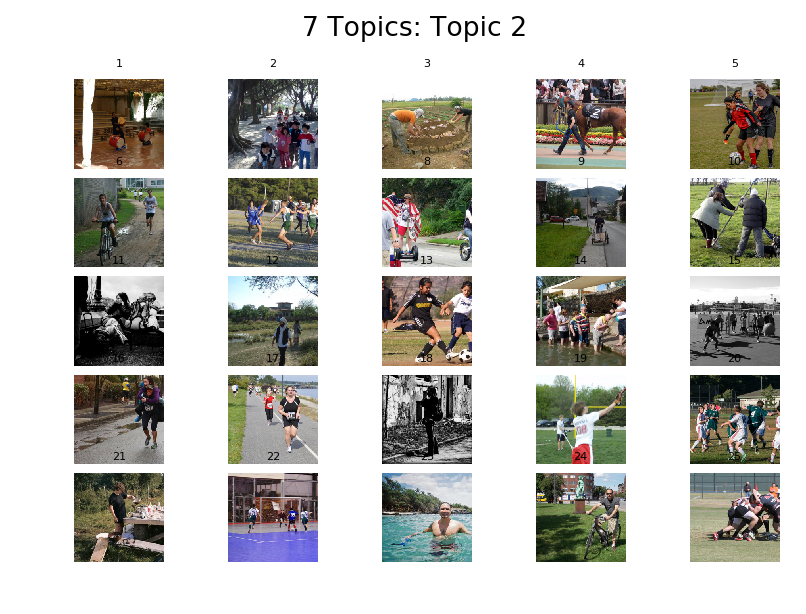

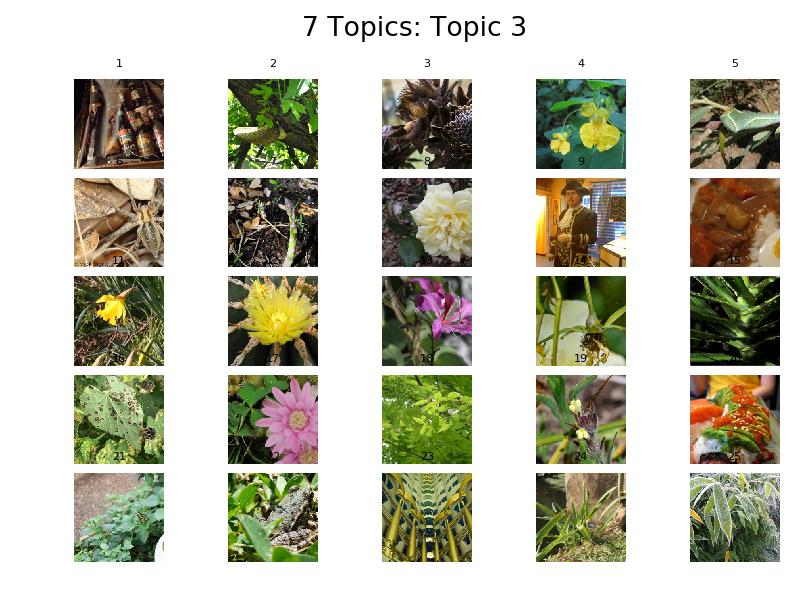

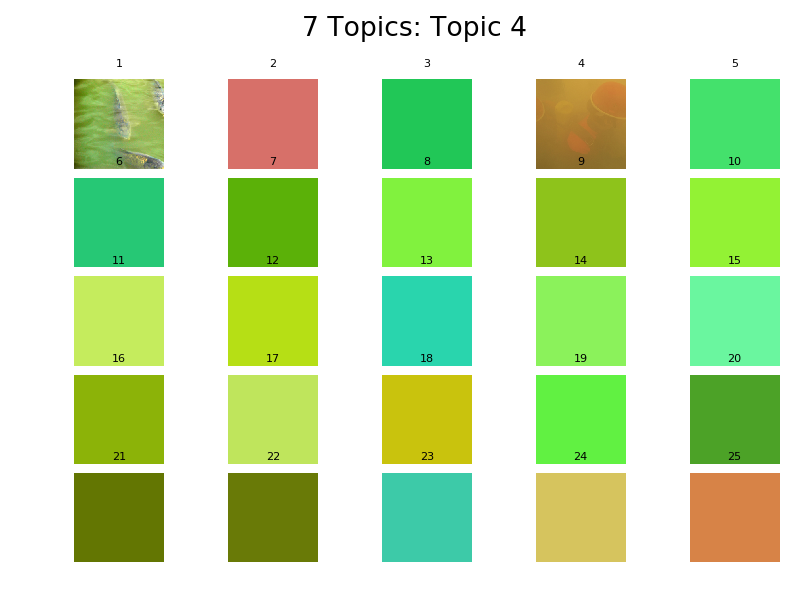

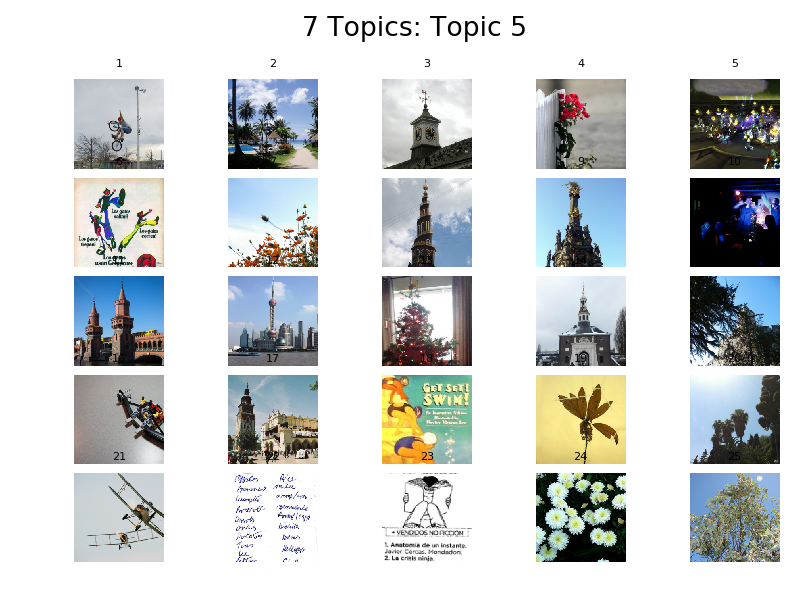

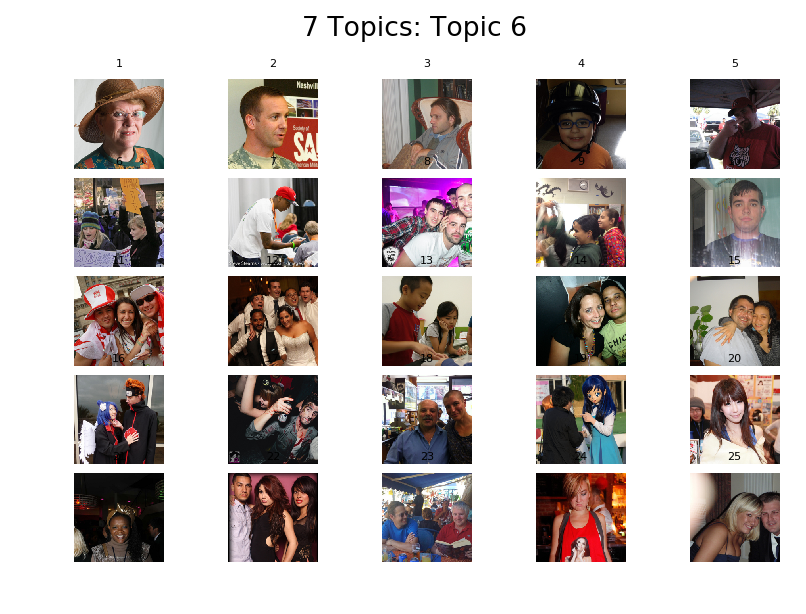

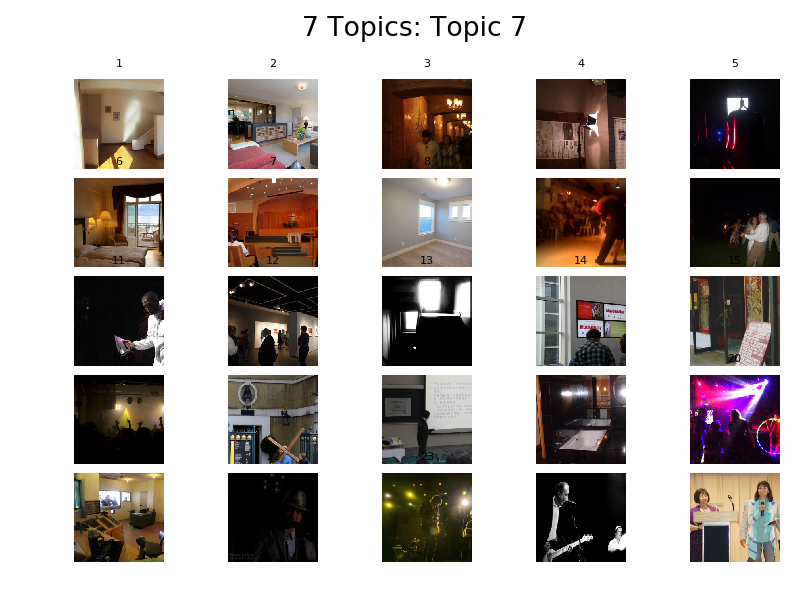

In [11]:
visualize(img_list, img_by_topic)

In [12]:
# For the images in the first topic
topic_range = range(NUM_TOPIC)
img_by_sub_topic = [[] for i in range(len(topic_range))]
for topic_id in topic_range:
    print("SUBTOPIC_ID: " + str(topic_id))
    im_count = len(img_by_topic[topic_id])
    imgs_num = [x[0] for x in img_by_topic[topic_id]]
    random.shuffle(imgs_num)
    
    corpus_sub = [[(j, X[i, j]) for j in range(NUM_FEATURE) if X[i, j]==1] for i in imgs_num]
    lda_sub = models.ldamodel.LdaModel(corpus_sub, num_topics = NUM_TOPIC)
    
    img_by_sub_topic[topic_id] = [[] for _ in range(NUM_TOPIC)]
    for i in range(im_count):
        ind, val = sorted(lda_sub.get_document_topics(corpus_sub[i]), key=lambda x:x[1])[-1]
        img_by_sub_topic[topic_id][ind].append((imgs_num[i], val))

SUBTOPIC_ID: 0


0


/home/will/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


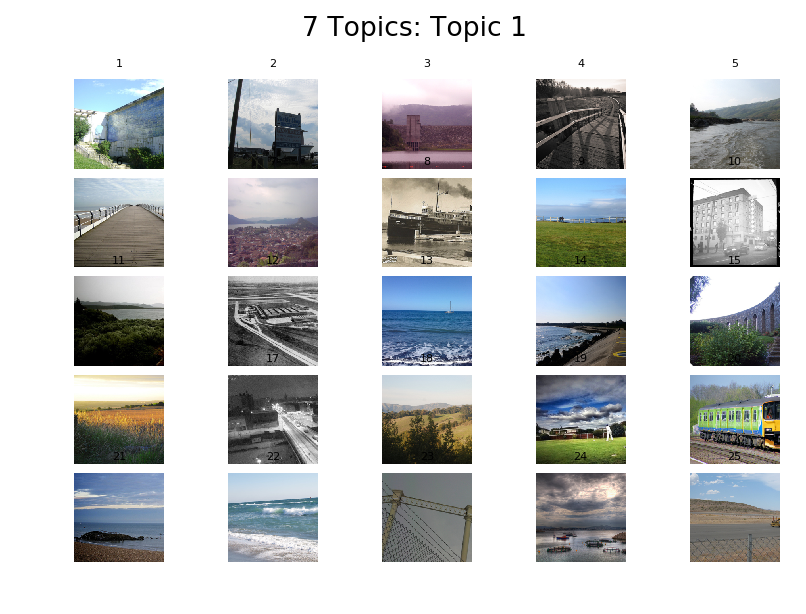

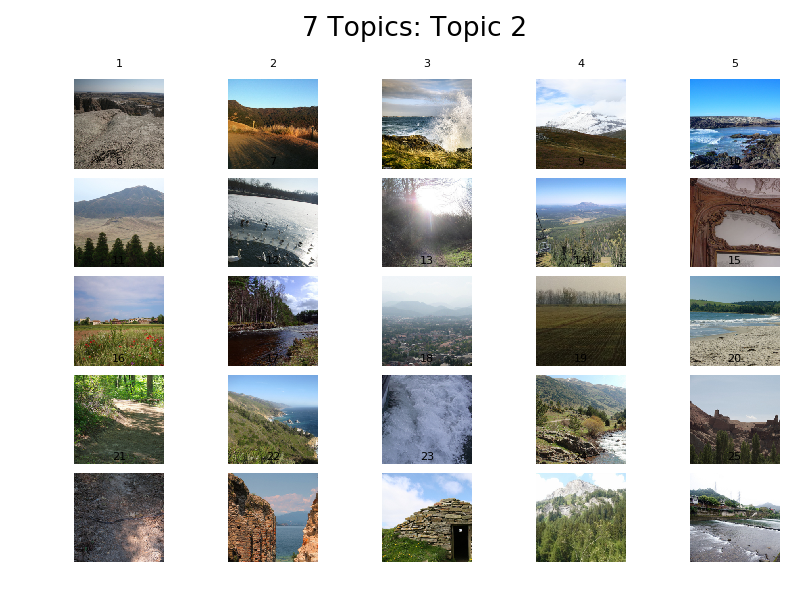

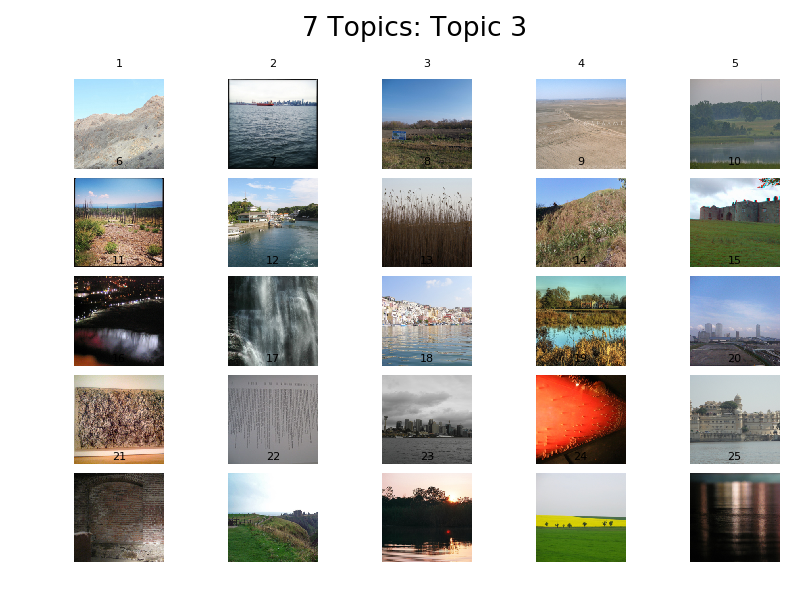

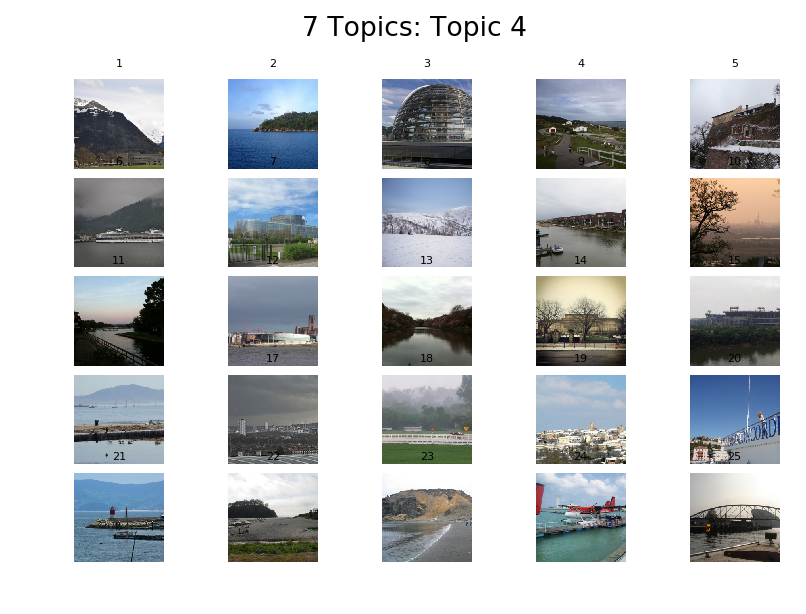

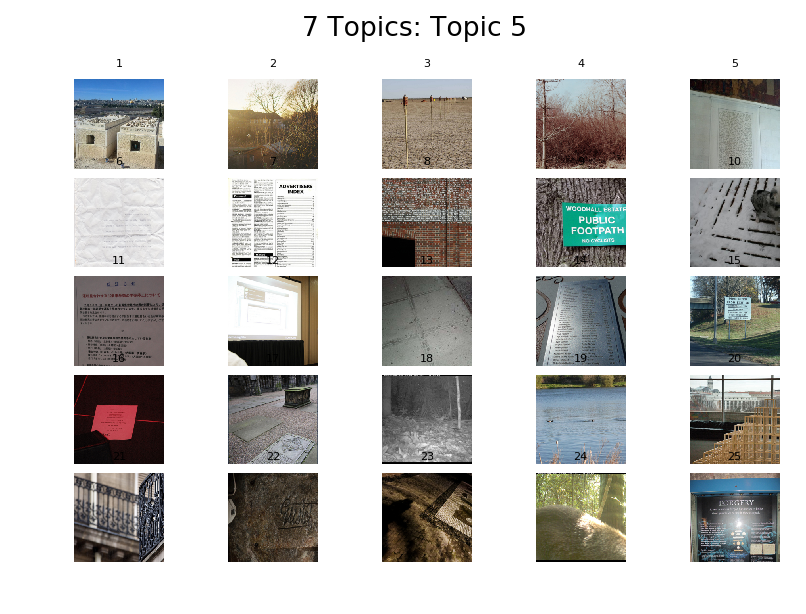

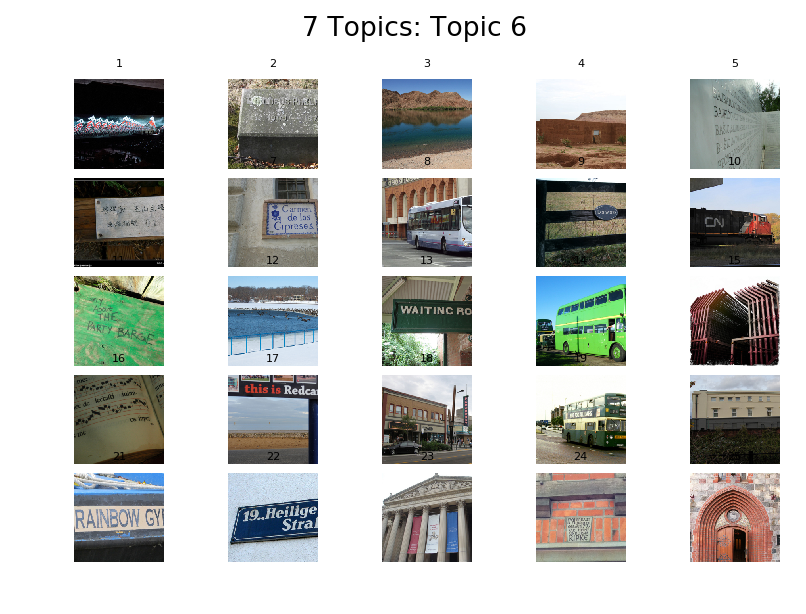

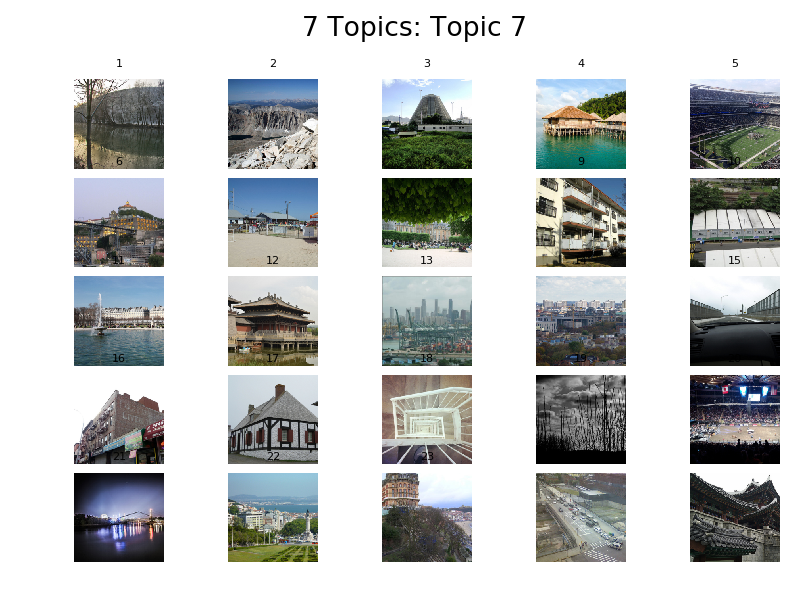

In [13]:
c = 0
for by in img_by_sub_topic:
    print("SubTopic: "+str(c))
    c += 1
    visualize(img_list, by)